In [1]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [2]:
import IPython


def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.formatters import HtmlFormatter
    from pygments.lexers import Python3Lexer
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [3]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer((128, 128), "float32"),
        B: T.Buffer((128, 128), "float32"),
        C: T.Buffer((128, 128), "float32"),
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

In [4]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

In [5]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 0.685 ms


In [6]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [7]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
IPython.display.HTML(code2html(sch.mod.script()))

In [8]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 0.193 ms


In [14]:
print(sch.trace)
print(type(sch.trace))

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  l4, l5 = sch.split(loop=l2, factors=[None, 4], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l4, l3, l5)
  b6 = sch.decompose_reduction(block=b0, loop=l3)
<class 'tvm.tir.schedule.trace.Trace'>


In [15]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [17]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

# IPython.display.HTML(code2html(sch.mod.script()))

In [15]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)

In [16]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])


In [17]:
j_0, j_1 = sch.split(loop=j, factors=j_factors)
sch.reorder(i, j_0, k, j_1)

In [18]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)


In [19]:
IPython.display.HTML(code2html(sch.mod.script()))

In [20]:
def random_search(mod: tvm.IRModule, num_trials=5):
    best_result = None
    best_sch = None

    for i in range(num_trials):
        sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
        lib = tvm.build(sch.mod, target="llvm")
        f_timer_after = lib.time_evaluator("main", tvm.cpu())
        result = f_timer_after(a_nd, b_nd, c_nd).mean

        print("=====Attempt %d, time-cost: %.3f ms====" % (i, result * 1000))
        print(sch.trace)

        # book keep the best result so far
        if best_result is None or result < best_result:
            best_result = result
            best_sch = sch

    return best_sch

sch = random_search(MyModule)

=====Attempt 0, time-cost: 0.130 ms====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 1, time-cost: 0.416 ms====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 2, time-cost: 0.415 ms====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get

In [21]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)


In [42]:
from tvm import meta_schedule as ms

database = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    max_trials_global=10,
    num_trials_per_iter=10,
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm), # annotate to use auto-scheduling
    work_dir="./tune_tmp",
)

sch = ms.tir_integration.compile_tir(database, MyModule, "llvm --num-cores=1")

2024-11-28 17:52:40 [INFO] Logging directory: ./tune_tmp/logs
2024-11-28 17:52:40 [INFO] LocalBuilder: max_workers = 10
2024-11-28 17:52:41 [INFO] LocalRunner: max_workers = 1
2024-11-28 17:52:41 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,N/A,N/A,N/A,0,


2024-11-28 17:52:41 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |      
------------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0

2024-11-28 17:52:41 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:52:42 [INFO] [task_scheduler.cc:193] Sending 5 sample(s) to builder
2024-11-28 17:52:42 [INFO] [task_scheduler.cc:195] Sending 5 sample(s) to runner
2024-11-28 17:52:44 [DEBUG] XGB iter   0: tr-p-rmse: 0.298303	tr-a-peak@32: 0.944063	tr-rmse: 0.319875	tr-rmse: 0.319875
2024-11-28 17:52:44 [DEBUG] XGB iter  25: tr-p-rmse: 0.111750	tr-a-peak@32: 1.000000	

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,46.9115,89.4089,89.4089,5,


2024-11-28 17:52:44 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        46.9115 |      89.4089 |               89.4089 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 89.4089


Total trials: 5
Total latency (us): 89.4089

2024-11-28 17:52:44 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:52:44 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder
2024-11-28 17:52:44 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner
2024-11-28 17:52:44 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,46.9115,89.4089,89.4089,5,


2024-11-28 17:52:44 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        46.9115 |      89.4089 |               89.4089 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 89.4089


Total trials: 5
Total latency (us): 89.4089

2024-11-28 17:52:44 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:52:44 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder
2024-11-28 17:52:44 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner
2024-11-28 17:52:44 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,46.9115,89.4089,89.4089,5,


2024-11-28 17:52:44 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        46.9115 |      89.4089 |               89.4089 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 89.4089


Total trials: 5
Total latency (us): 89.4089

2024-11-28 17:52:44 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,46.9115,89.4089,89.4089,5,


2024-11-28 17:52:45 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        46.9115 |      89.4089 |               89.4089 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 89.4089


Total trials: 5
Total latency (us): 89.4089

2024-11-28 17:52:45 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,46.9115,89.4089,89.4089,5,


2024-11-28 17:52:45 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        46.9115 |      89.4089 |               89.4089 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 89.4089


Total trials: 5
Total latency (us): 89.4089

2024-11-28 17:52:45 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:52:45 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,46.9115,89.4089,89.4089,5,Y


2024-11-28 17:52:45 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        46.9115 |      89.4089 |               89.4089 |      5 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 89.4089


Total trials: 5
Total latency (us): 89.4089



In [43]:
sch.trace.show()

In [45]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.089 ms


In [46]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

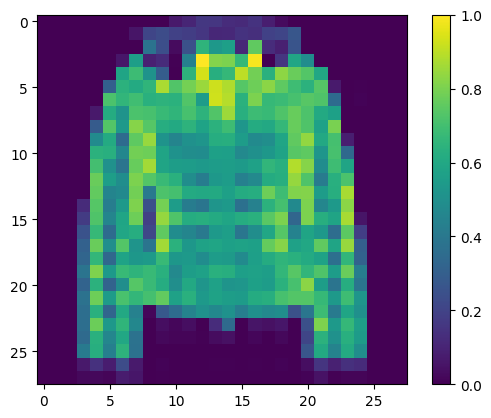

Class: Coat


In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [48]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [49]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"),
                W: T.Buffer((128, 784), "float32"),
                B: T.Buffer((128,), "float32"),
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [50]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [51]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [52]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Coat


In [79]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.106019 ms


In [54]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
IPython.display.HTML(code2html(mod_linear.script()))

In [55]:
database = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
)
sch = ms.tir_integration.compile_tir(database, mod_linear, "llvm --num-cores=1")

2024-11-28 17:53:44 [INFO] Logging directory: ./tune_tmp/logs
2024-11-28 17:53:44 [INFO] LocalBuilder: max_workers = 10
2024-11-28 17:53:45 [INFO] LocalRunner: max_workers = 1
2024-11-28 17:53:45 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,N/A,N/A,N/A,0,


2024-11-28 17:53:45 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |      
-----------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0

2024-11-28 17:53:45 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-11-28 17:53:46 [INFO] [task_scheduler.cc:193] Sending 64 sample(s) to builder
2024-11-28 17:53:51 [INFO] [task_scheduler.cc:195] Sending 64 sample(s) to runner
2024-11-28 17:54:03 [DEBUG] XGB iter   0: tr-p-rmse: 0.379239	tr-a-peak@32: 1.000000	tr-rmse: 0.267173	tr-rmse: 0.267173
2024-11-28 17:54:03 [DEBUG] XGB iter  25: tr-p-rmse: 0.033066	tr-a-peak@32: 1.000000	tr

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,47.6981,4.2105,4.2105,64,



Total trials: 64
Total latency (us): 4.21048

2024-11-28 17:54:03 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        47.6981 |       4.2105 |                4.2105 |     64 |      
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 4.21048

2024-11-28 17:54:03 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,47.6981,4.2105,4.2105,64,Y


2024-11-28 17:54:03 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        47.6981 |       4.2105 |                4.2105 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 4.21048


Total trials: 64
Total latency (us): 4.21048



In [56]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)
IPython.display.HTML(code2html(MyModuleWithParams2.script()))

In [57]:
ex = relax.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Coat


In [62]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.0629206 ms
